In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys

if '..' not in sys.path:
    sys.path.append('..')

from data import ThreeBallsCollisionsDataset

import torch
from torch.utils.data import DataLoader

import reservoirpy as rpy
from reservoirpy.nodes import Input, Reservoir, Ridge, ReLU, ESN
from reservoirpy.observables import mse

from itertools import product

from tqdm.notebook import tqdm_notebook

rpy.verbosity(0)
rpy.set_seed(42)

In [2]:
def calculate_test_loss(model, dataloader, dataset, visualize_first_10_trajectories=True):
    test_loss = (np.sum(
        [mse(model.run(X.squeeze().numpy()), y.squeeze().numpy())*len(y) for X, y in tqdm_notebook(dataloader)]) / 
        len(dataset)) ** 0.5
    print('Test loss: ', test_loss)

    if visualize_first_10_trajectories:
        fig1, axs1 = plt.subplots(2, 5, figsize=(20,10))
        fig2, axs2 = plt.subplots(2, 5, figsize=(20,10))
        fig3, axs3 = plt.subplots(2, 5, figsize=(20,10))

        fig1.suptitle('Y-coordinate over time')
        fig2.suptitle('X-coordinate over time')
        fig3.suptitle('Trajectory')

        plt.setp(axs1[-1, :], xlabel='Frame number')
        plt.setp(axs1[:, 0], ylabel='Y-coordinate')

        plt.setp(axs2[-1, :], xlabel='Frame number')
        plt.setp(axs2[:, 0], ylabel='X-coordinate')

        plt.setp(axs3[-1, :], xlabel='X-coordinate')
        plt.setp(axs3[:, 0], ylabel='Y-coordinate')

        # setting the plot ranges to be between 0 and 1 to represent the entire scene
        for row_id in range(len(axs1)):
            for col_id in range(len(axs1[row_id])):
                # axs1 and axs2 are time series, so only limiting y-axis
                axs1[row_id, col_id].set_ylim(0, 1)
                axs2[row_id, col_id].set_ylim(0, 1)

                # axs3 shows trajectories, so limiting both axis
                axs3[row_id, col_id].set_xlim(0, 1)
                axs3[row_id, col_id].set_ylim(0, 1)


        plt.title('Y-coordinates over time')
        for X, y in dataloader:
            pred = model.run(X.squeeze().numpy())

            for count in range(10):
                gr = np.insert(y.squeeze().numpy()[count].reshape(1,-1)[0], 0, X.squeeze().numpy()[count][-3:-1])
                pr = np.insert(pred.squeeze()[count].reshape(1,-1)[0], 0, X.squeeze().numpy()[count][-3:-1])

                axs1[int(count >= 5)][count % 5].plot(gr[1::2], label=f'Ground truth')
                axs1[int(count >= 5)][count % 5].plot(pr[1::2], label='Predicted')
                axs1[int(count >= 5)][count % 5].legend()

                axs2[int(count >= 5)][count % 5].plot(gr[0::2], label=f'Ground truth')
                axs2[int(count >= 5)][count % 5].plot(pr[0::2], label='Predicted')
                axs2[int(count >= 5)][count % 5].legend()

                axs3[int(count >= 5)][count % 5].plot(gr[0::2], gr[1::2], label=f'Ground truth')
                axs3[int(count >= 5)][count % 5].plot(pr[0::2], pr[1::2], label='Predicted')
                axs3[int(count >= 5)][count % 5].legend()

            break

        plt.show()
    return test_loss

In [3]:
batch_size = 64

train_data, test_data = ThreeBallsCollisionsDataset.train_test_split('../data/raw/three-balls-collisions-full-old', test_frac=0.2, max_actions=5000)

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)

Test size:  91259
train_test_split response: test fraction rounded to 0.1999986850698447 (91259 simulations)


In [4]:
# Parameters for cross-validation hyperparameter turning

n_units = [150, 200, 250]
lrs = [0.9, 0.95]
srs = [0.01, 0.1, 0.3, 0.5]
ridges = [0.1, 0.3, 0.4]

In [5]:
# dictionary to store the results

import pickle

results = {}

results_file = 'results_dict_collisions.pkl'

try:
    with open(results_file, 'rb') as f:
        results = pickle.load(f)
except:
    results = {}

In [6]:
if results == {}:

    # Performing cross-validation hypterparameter turning

    results['simple_esn'] = []

    for units, lr, sr, ridge in tqdm_notebook(product(n_units, lrs, srs, ridges)):
        print(f'Testing units={units} \t lr={lr} \t sr={sr} \t ridge={ridge}')

        rpy.set_seed(42)

        reservoir1 = Reservoir(units=units, lr=lr, sr=sr, input_bias=False)
        readout1 = Ridge(output_dim=48, ridge=ridge) >> ReLU()

        model1 = reservoir1 >> readout1

        for X, y in train_dataloader:
            model1.fit(X.squeeze().numpy(), y.squeeze().numpy())

        test_loss = calculate_test_loss(model1, test_dataloader, test_data, visualize_first_10_trajectories=False)

        results['simple_esn'].append(
            {
                'units': units,
                'lr': lr,
                'sr': sr,
                'ridge': ridge,
                'test_loss': test_loss
            }
        )

        print()

        with open(results_file, 'wb') as f:
            pickle.dump(results, f)

Best result:  {'units': 200, 'lr': 0.9, 'sr': 0.5, 'ridge': 0.4, 'test_loss': 0.06307378670333609}


Training progress:   0%|          | 0/5835 [00:00<?, ?it/s]

  0%|          | 0/1426 [00:00<?, ?it/s]

Test loss:  0.06366244011146589


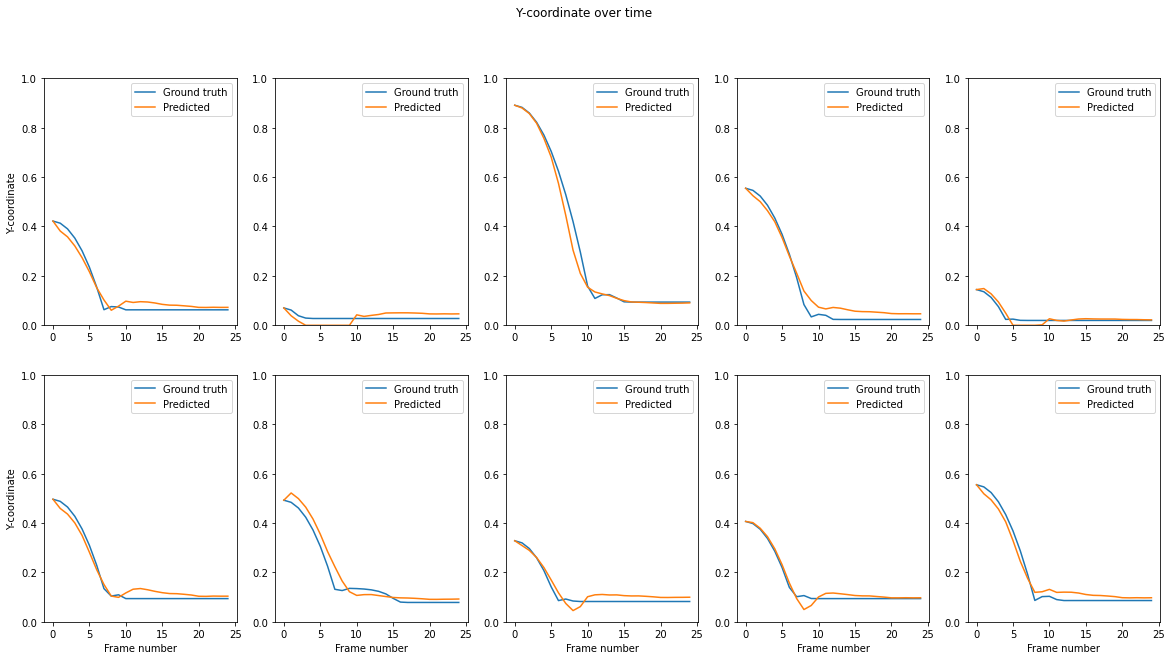

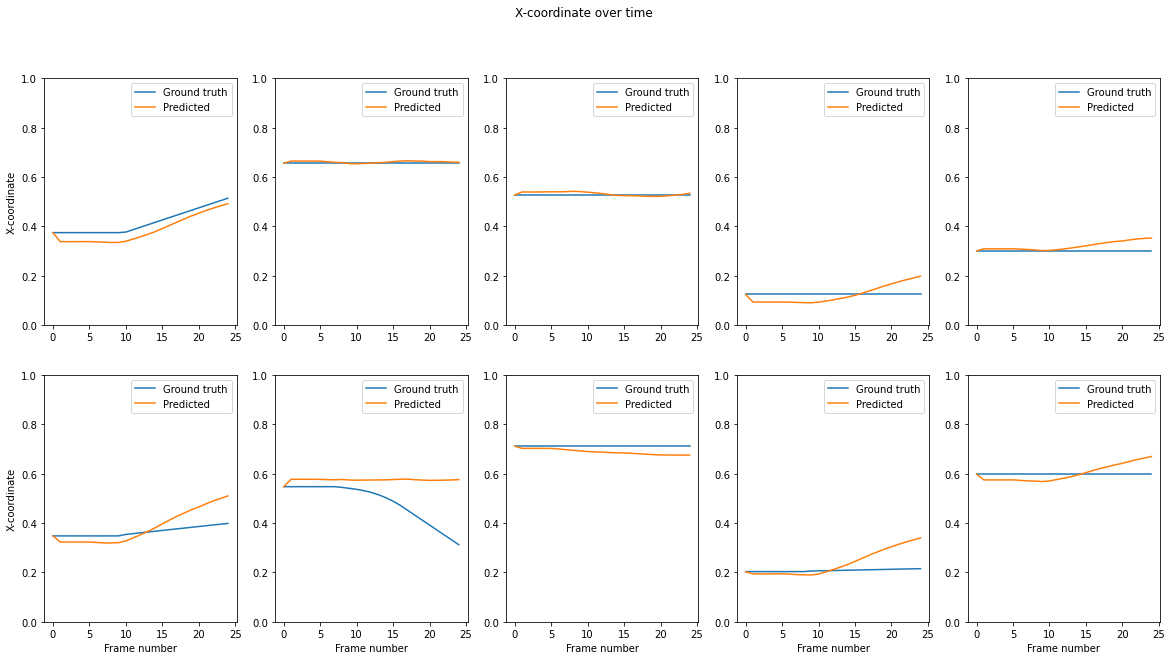

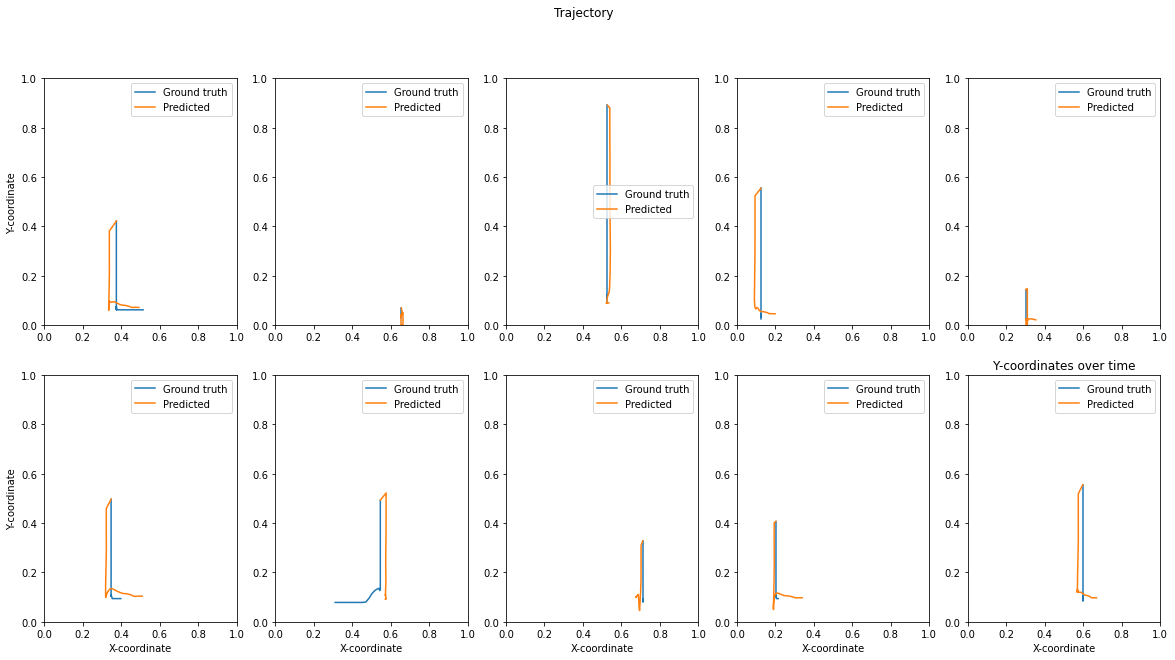

In [7]:
best_result = min(results['simple_esn'], key=lambda x: x['test_loss'])

print('Best result: ', best_result)

rpy.set_seed(42)

reservoir1 = Reservoir(units=best_result['units'], lr=best_result['lr'], sr=best_result['sr'], input_bias=False)
readout1 = Ridge(output_dim=48, ridge=best_result['ridge']) >> ReLU()

model1 = reservoir1 >> readout1

for X, y in tqdm_notebook(train_dataloader, desc='Training progress'):
    model1.fit(X.squeeze().numpy(), y.squeeze().numpy())

test_loss = calculate_test_loss(model1, test_dataloader, test_data, visualize_first_10_trajectories=True)

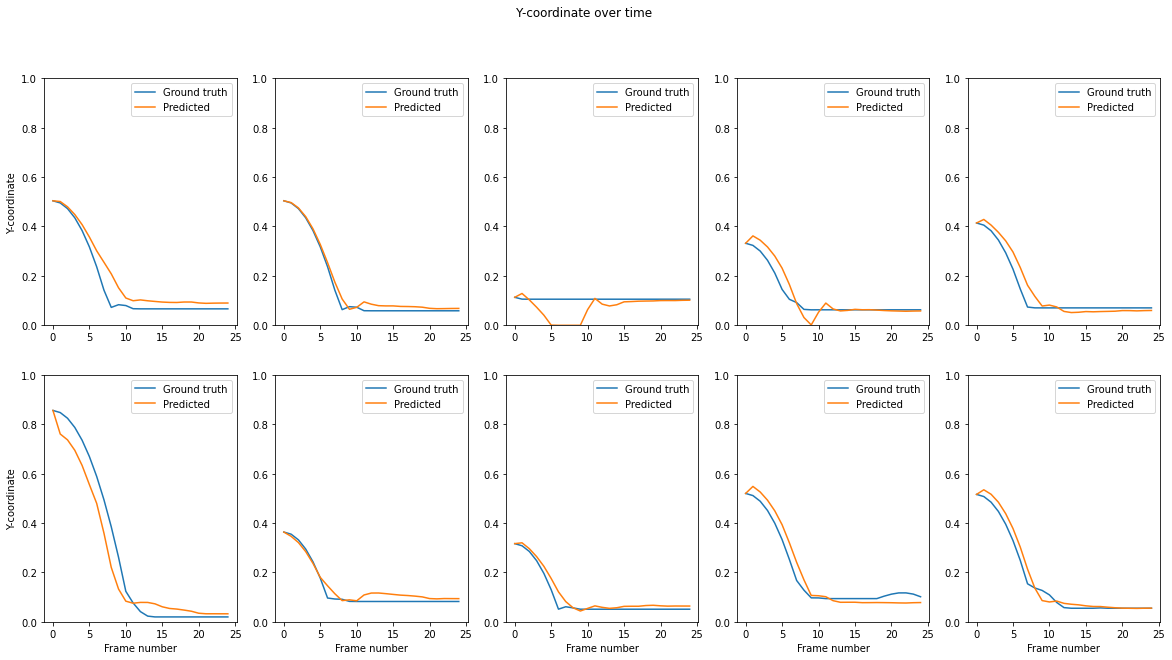

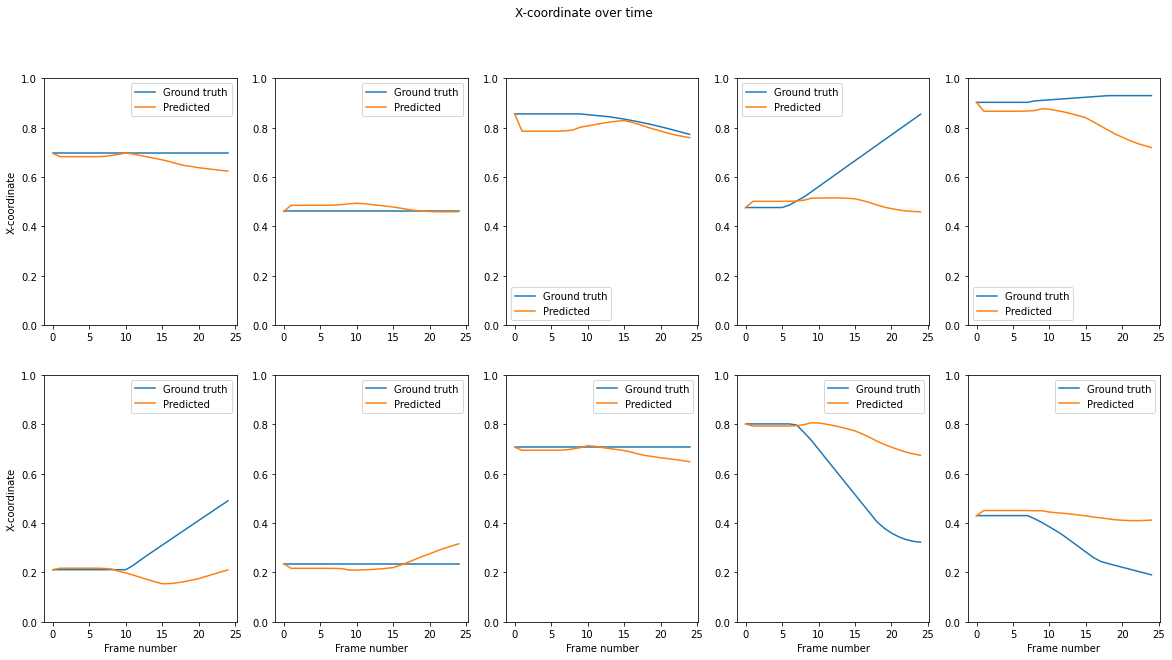

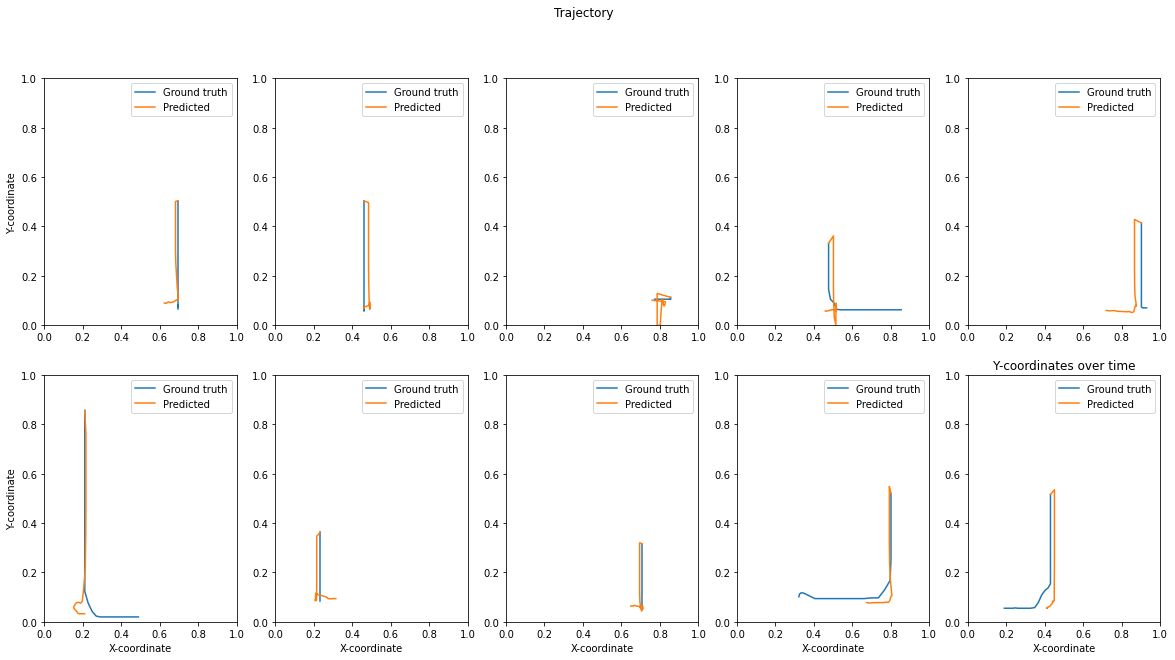

In [ ]:
fig1, axs1 = plt.subplots(2, 5, figsize=(20,10))
fig2, axs2 = plt.subplots(2, 5, figsize=(20,10))
fig3, axs3 = plt.subplots(2, 5, figsize=(20,10))


fig1.suptitle('Y-coordinate over time')
fig2.suptitle('X-coordinate over time')
fig3.suptitle('Trajectory')

plt.setp(axs1[-1, :], xlabel='Frame number')
plt.setp(axs1[:, 0], ylabel='Y-coordinate')

plt.setp(axs2[-1, :], xlabel='Frame number')
plt.setp(axs2[:, 0], ylabel='X-coordinate')

plt.setp(axs3[-1, :], xlabel='X-coordinate')
plt.setp(axs3[:, 0], ylabel='Y-coordinate')

shift = 53

# setting the plot ranges to be between 0 and 1 to represent the entire scene
for row_id in range(len(axs1)):
    for col_id in range(len(axs1[row_id])):
        # axs1 and axs2 are time series, so only limiting y-axis
        axs1[row_id, col_id].set_ylim(0, 1)
        axs2[row_id, col_id].set_ylim(0, 1)

        # axs3 shows trajectories, so limiting both axis
        axs3[row_id, col_id].set_xlim(0, 1)
        axs3[row_id, col_id].set_ylim(0, 1)


plt.title('Y-coordinates over time')
for X, y in test_dataloader:
    pred = model1.run(X.squeeze().numpy())

    for count in range(10):
        gr = np.insert(y.squeeze().numpy()[count+shift].reshape(1,-1)[0], 0, X.squeeze().numpy()[count+shift][-3:-1])
        pr = np.insert(pred.squeeze()[count+shift].reshape(1,-1)[0], 0, X.squeeze().numpy()[count+shift][-3:-1])

        axs1[int(count >= 5)][count % 5].plot(gr[1::2], label=f'Ground truth')
        axs1[int(count >= 5)][count % 5].plot(pr[1::2], label='Predicted')
        axs1[int(count >= 5)][count % 5].legend()

        axs2[int(count >= 5)][count % 5].plot(gr[0::2], label=f'Ground truth')
        axs2[int(count >= 5)][count % 5].plot(pr[0::2], label='Predicted')
        axs2[int(count >= 5)][count % 5].legend()

        axs3[int(count >= 5)][count % 5].plot(gr[0::2], gr[1::2], label=f'Ground truth')
        axs3[int(count >= 5)][count % 5].plot(pr[0::2], pr[1::2], label='Predicted')
        axs3[int(count >= 5)][count % 5].legend()

    break

plt.show()